In [1]:
from tqdm import tqdm
import os
from datetime import datetime
from time import time
import pandas as pd
from src.datasets import TextConcatFactCheck, TextConcatPosts
from src.models import EmbeddingModel
from src import config
from src.utils import log_info
import spacy
from tqdm import tqdm
import numpy as np
tqdm.pandas()
def extract_entities(text):
    # get hashtags
    hashtags = [word[1:] for word in text.split() if word.startswith("#")]
    text = text.replace("#", "")
    
    ents_0 = nlp(text).ents
    # get ents ngrams from 1 to 3

    return [ent.text for ent in ents_0] + hashtags

task_name = "monolingual"
langs = ["eng"]
lang = "fra"
output_path = None
model_name = '/home/bsc/bsc830651/.cache/huggingface/hub/models--intfloat--multilingual-e5-large/snapshots/ab10c1a7f42e74530fe7ae5be82e6d4f11a719eb'
tasks_path = config.TASKS_PATH
posts_path = config.POSTS_PATH
fact_checks_path = config.FACT_CHECKS_PATH

"""
Run the task with the given parameters.
"""
current_time = datetime.now().strftime("%Y%m%d-%H%M%S")

if output_path is not None:
    output_path = os.path.join(output_path, task_name, current_time)

# langs = ["eng"] if task_name == "crosslingual" else langs

log_info(f"Task: {task_name}")
log_info(f"Tasks path: {tasks_path}")
# log_info(f"Languages: {langs}")
log_info(f"Model: {model_name}")
log_info(f"Output path: {output_path}\n")

# Paths from config
posts_path = config.POSTS_PATH
fact_checks_path = config.FACT_CHECKS_PATH
gs_path = config.GS_PATH

# tasks_path = "data/splits/tasks_local_dev.json"
ls_k = [1, 3, 5, 10]

d_out = {}
df_eval = pd.DataFrame(index=ls_k)
df_eval.index.name = "k"

# for lang in tqdm(langs, desc="Languages"):

log_info(f"Lang: {lang}")
time_start_lang = time()

log_info("Loading posts...")
time_start = time()
posts = TextConcatPosts(posts_path, tasks_path, task_name=task_name, gs_path=gs_path, lang=lang, clean=True)
posts_en = TextConcatPosts(posts_path, tasks_path, task_name=task_name, gs_path=gs_path, lang=lang, version="english", clean=True)

log_info(f"Loaded {len(posts)}")
log_info(f"Time taken: {time() - time_start:.2f}s\n")

log_info("Loading fact checks..")
time_start = time()
fact_checks = TextConcatFactCheck(fact_checks_path, tasks_path, task_name=task_name, lang=lang, clean=True)
fact_checks_en = TextConcatFactCheck(fact_checks_path, tasks_path, task_name=task_name, lang=lang, version="english", clean=True)

log_info(f"Loaded {len(fact_checks)}")
log_info(f"Time taken: {time() - time_start:.2f}s\n")

df_posts_train = posts.df_train
df_posts_train_en = posts_en.df_train

df_fc = fact_checks.df
df_fc = fact_checks_en.df

df_posts_dev = posts.df_dev
df_posts_dev_en = posts_en.df_dev


nlp = spacy.load("en_core_web_sm")

df_posts_train["lemmas"] = df_posts_train_en["full_text"].progress_apply(lambda x: [y.lemma_ for y in nlp(x) if y.is_stop == False and y.is_punct == False and y.is_space == False and y.is_alpha == True])
df_posts_train["entities"] = df_posts_train_en["full_text"].progress_apply(extract_entities)
df_posts_train["entities_lemmas"] = df_posts_train["entities"] + df_posts_train["lemmas"]

# df_posts_dev["lemmas"] = df_posts_dev["full_text"].progress_apply(lambda x: [y.lemma_ for y in nlp(x) if y.is_stop == False and y.is_punct == False and y.is_space == False and y.is_alpha == True])
# df_posts_dev["entities"] = df_posts_dev["full_text"].progress_apply(extract_entities)

df_fc["lemmas"] = df_fc["full_text"].progress_apply(lambda x: [y.lemma_ for y in nlp(x) if y.is_stop == False and y.is_punct == False and y.is_space == False and y.is_alpha == True])
df_fc["entities"] = df_fc["full_text"].progress_apply(extract_entities)
df_fc["entities_lemmas"] = df_fc["entities"] + df_fc["lemmas"]

log_info("Loading model...")
# time_start = time()
# model = EmbeddingModel(model_name, df_fc, batch_size=512)
# log_info(f"Time taken: {time() - time_start:.2f}s\n")

/home/bsc/bsc830651/.conda/envs/factcheck/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
2024-10-26 19:48:57,951 - INFO - Task: monolingual
2024-10-26 19:48:57,951 - INFO - Tasks path: data/splits/tasks_no_gs_overlap.json
2024-10-26 19:48:57,952 - INFO - Model: /home/bsc/bsc830651/.cache/huggingface/hub/models--intfloat--multilingual-e5-large/snapshots/ab10c1a7f42e74530fe7ae5be82e6d4f11a719eb
2024-10-26 19:48:57,952 - INFO - Output path: None

2024-10-26 19:48:57,954 - INFO - Lang: fra
2024-10-26 19:48:57,955 - INFO - Loading posts...
2024-10-26 19:49:03,554 - INFO - Loaded 24431
2024-10-26 19:49:03,555 - INFO - Time taken: 5.60s

2024-10-26 19:49:03,556 - INFO - Loading fact checks..
2024-10-26 19:49:07,478 - INFO - Loaded 4355
2024-10-26 19:49:07,479 - INFO - Time ta

In [2]:
fc_entities = df_fc.entities.apply(set).to_list()
fc_lemmas = df_fc.lemmas.apply(set).to_list()
fc_entities_lemmas = df_fc.entities_lemmas.apply(set).to_list()

from tqdm import tqdm
import numpy as np
tqdm.pandas()
pos_to_idx = dict(enumerate(df_fc.index))
map_pos_to_idx = np.vectorize(lambda x: pos_to_idx[x])
df_posts_train["entities_lemmas"] = df_posts_train["entities"] + df_posts_train["lemmas"]

def get_word_intersection(x, y):
    set_words_in_common = set(x).intersection(y)
    return list(set_words_in_common)

# def get_word_intersection_len(x, y):
#     return len(get_word_intersection(x, y))

df_posts_train["common_entities_lemmas"] = df_posts_train["entities_lemmas"].progress_apply(lambda x: [get_word_intersection(x, fc_el) for fc_el in fc_entities_lemmas])
df_posts_train["len_common_entities_lemmas"] = df_posts_train["common_entities_lemmas"].progress_apply(lambda x: [len(y) for y in x])
df_posts_train["max_len_entities_lemmas"] = df_posts_train["len_common_entities_lemmas"].progress_apply(np.max)
df_posts_train["idx_entities_lemmas"] = df_posts_train["len_common_entities_lemmas"].progress_apply(lambda x: map_pos_to_idx(np.argsort(x)[::-1]))

df_posts_train["common_entities"] = df_posts_train["entities"].progress_apply(lambda x: [get_word_intersection(x, fc_el) for fc_el in fc_entities])
df_posts_train["len_common_entities"] = df_posts_train["common_entities"].progress_apply(lambda x: [len(y) for y in x])
df_posts_train["max_len_entities"] = df_posts_train["len_common_entities"].progress_apply(np.max)
df_posts_train["idx_entities"] = df_posts_train["len_common_entities"].progress_apply(lambda x: map_pos_to_idx(np.argsort(x)[::-1]))


df_posts_train["common_lemmas"] = df_posts_train["lemmas"].progress_apply(lambda x: [get_word_intersection(x, fc_el) for fc_el in fc_lemmas])
df_posts_train["len_common_lemmas"] = df_posts_train["common_lemmas"].progress_apply(lambda x: [len(y) for y in x])
df_posts_train["max_len_lemmas"] = df_posts_train["len_common_lemmas"].progress_apply(np.max)
df_posts_train["idx_lemmas"] = df_posts_train["len_common_lemmas"].progress_apply(lambda x: map_pos_to_idx(np.argsort(x)[::-1]))
# df_posts_train["len_lemmas"] = df_posts_train["lemmas"].progress_apply(lambda x: np.max([len(set(x).intersection(fc_lemmas[i])) for i in range(len(fc_lemmas))]))
# df_posts_train["idx_lemmas"] = df_posts_train["lemmas"].progress_apply(lambda x: map_pos_to_idx(np.argsort([len(set(x).intersection(fc_lemmas[i])) for i in range(len(fc_lemmas))])[:10:-1])
                                                                       
# df_posts_train["idx_lemmas"] = df_posts_train["idx_lemmas"].map(pos_to_idx)

  0%|          | 0/1443 [00:00<?, ?it/s]

100%|██████████| 1443/1443 [00:00<00:00, 2166.15it/s]


In [5]:
from src.models import BaseModel
model = BaseModel()

def evaluate_using_col(df, col):
    df_eval = df.copy()
    df_eval["preds"] = df_eval[col]
    return model.evaluate(df_eval, task_name=task_name, lang=lang)

d_eval_lemmas = evaluate_using_col(df_posts_train, "idx_lemmas")
d_eval_entities = evaluate_using_col(df_posts_train, "idx_entities")
d_eval_entities_lemmas = evaluate_using_col(df_posts_train, "idx_entities_lemmas")

print("Lemmas: ", d_eval_lemmas)
print("Entities: ", d_eval_entities)
print("Entities + Lemmas: ", d_eval_entities_lemmas)

Lemmas:  {'monolingual': {'fra': {1: 0.06999306999306999, 3: 0.11157311157311157, 5: 0.13513513513513514, 10: 0.176022176022176}}}
Entities:  {'monolingual': {'fra': {1: 0.11365211365211365, 3: 0.1794871794871795, 5: 0.21067221067221067, 10: 0.25017325017325015}}}
Entities + Lemmas:  {'monolingual': {'fra': {1: 0.5031185031185031, 3: 0.6292446292446292, 5: 0.681912681912682, 10: 0.7428967428967429}}}


In [13]:
# from src.models import IEModel
# reload library
from importlib import reload
import src.models

reload(src.models)
from src.models import IEModel

model = IEModel(model_name="en_core_web_sm", df_fc=df_fc)

: 

In [11]:
model.vectorized_map(df_posts_train["full_text"].values)

In [12]:
texts = df_posts_train["full_text"].iloc[:2]
emb_texts = model.encode(texts)

common_entity_lemmas = emb_texts.apply(lambda x: [model.get_word_intersection(x, fc_el) for fc_el in model.emb_fc])
len_common_entities_lemmas = common_entity_lemmas.apply(lambda x: [len(y) for y in x])

positions = len_common_entities_lemmas.apply(lambda x: np.argsort(x)[::-1])
preds = len_common_entities_lemmas.apply(lambda x: model.vectorized_map(positions))

positions

post_id
64    [1975, 3108, 188, 3018, 3019, 3961, 887, 2257,...
79    [606, 3018, 1975, 1767, 1773, 1040, 3019, 3558...
Name: full_text, dtype: object

In [5]:
out = model.predict(df_posts_train["full_text"].iloc[:2])

post_id
64    [None, None, None, None, None, None, None, Non...
79    [None, None, None, None, None, None, None, Non...
Name: full_text, dtype: object


In [61]:
model.emb_fc

fact_check_id
15        [whatsapp, martinelli, video, contaminate, pho...
136       [fatou, sarr, sow, wrong, female, literacy, ra...
155       [true, effect, covid, vaccine, vaccine, relate...
156       [congolese, authority, record, surrender, arme...
187       [senegal, student, use, drug, student, use, dr...
                                ...                        
156402    [désinfox, caregiver, lay, vaccinate, fire, ca...
156686    [false, image, connection, year, old, woman, n...
156687    [smart, lamppost, destroy, protester, hong, ko...
156688    [rig, photo, shop, prague, prague, shopkeeper,...
156770    [turtle, picture, find, african, continent, ag...
Name: full_text, Length: 4355, dtype: object

In [50]:
np.array([[1, 2, 3], [4, 5, 6]]).shape

(2, 3)

In [51]:
vect = np.vectorize(np.sum)
vect(np.array([[1, 2, 3], [4, 5, 6]]))

array([[1, 2, 3],
       [4, 5, 6]])

In [59]:
vectorized_extract_entities = np.vectorize(lambda x: extract_entities(x))
vectorized_extract_entities(df_fc["full_text"].to_list()[:1])

ValueError: setting an array element with a sequence

In [8]:
df_posts_train["max_len_entities_lemmas"].value_counts().sort_index()

max_len_entities_lemmas
0       1
1      33
2     128
3     205
4     251
5     219
6     161
7     133
8      91
9      71
10     36
11     39
12     21
13     20
14      8
15      7
16      9
18      4
19      2
21      1
23      1
24      1
28      1
Name: count, dtype: int64

In [9]:
df_posts_train["max_len_entities"].value_counts().sort_index()

max_len_entities
0    259
1    634
2    408
3    119
4     18
5      4
6      1
Name: count, dtype: int64

In [10]:
df_posts_train["max_len_lemmas"].value_counts().sort_index()

max_len_lemmas
0    488
1    609
2    262
3     76
4      3
5      4
6      1
Name: count, dtype: int64

In [18]:
df_posts_train.columns

Index(['ocr', 'verdicts', 'text', 'lan', 'fb', 'tw', 'ig', 'full_text', 'gs',
       'lemmas', 'entities', 'entities_lemmas', 'common_entities_lemmas',
       'len_common_entities_lemmas', 'max_len_entities_lemmas',
       'idx_entities_lemmas', 'common_entities', 'len_common_entities',
       'max_len_entities', 'idx_entities', 'common_lemmas',
       'len_common_lemmas', 'max_len_lemmas', 'idx_lemmas'],
      dtype='object')

In [38]:
def get_scores(n_ents, n_lemmas, total_ents, total_lemmas):
    rel_ents = n_ents / (total_ents + 0.01)
    rel_lemmas = n_lemmas / (total_lemmas + 0.01)
    score = rel_lemmas ** (1 + rel_ents)
    return score

map_get_scores = np.vectorize(get_scores)
scores = df_posts_train.apply(lambda x: map_get_scores(x["len_common_entities"], x["len_common_lemmas"], len(x["entities"]), len(x["lemmas"])), axis=1)

df_posts_train["idx_scores"] = scores.apply(lambda x: map_pos_to_idx(np.argsort(x)[::-1]))


In [39]:
df_posts_train["idx_scores"]

post_id
64       [15, 156770, 156688, 6412, 6298, 5171, 5116, 4...
79       [15, 156770, 156688, 6412, 6298, 5171, 5116, 4...
86       [84298, 153954, 76175, 76219, 76220, 76574, 76...
182      [25549, 137913, 138020, 83468, 79381, 137347, ...
192      [79554, 137097, 36668, 82796, 138015, 9980, 36...
                               ...                        
28017    [79946, 76175, 76219, 76220, 76574, 76596, 765...
28018    [79946, 76175, 76219, 76220, 76574, 76596, 765...
28024    [15, 156770, 156688, 6412, 6298, 5171, 5116, 4...
28030    [82465, 155770, 138170, 4866, 84298, 155758, 2...
28089    [83564, 83512, 83511, 83565, 83566, 82691, 826...
Name: idx_scores, Length: 1443, dtype: object

In [40]:
evaluate_using_col(df_posts_train, "idx_scores")

{'monolingual': {'fra': {1: 0.04851004851004851,
   3: 0.09009009009009009,
   5: 0.1101871101871102,
   10: 0.15246015246015246}}}

In [ ]:
df_scores = pd.DataFrame

<Axes: >

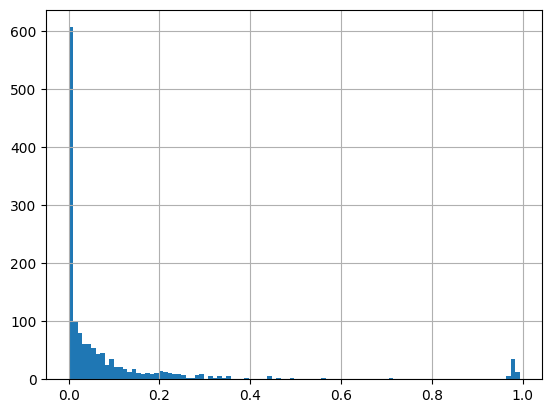

In [26]:
scores.map(lambda x: np.mean(np.sort(x)[::-1][:10])).hist(bins=100)

In [13]:
df_analysis = df_posts_train.copy()

df_analysis["full_text_en"] = df_posts_train_en["full_text"]
df_analysis["full_text_gs"] = df_posts_train["gs"].apply(lambda x: [df_fc.loc[y, "full_text"] for y in x])
df_analysis["entities_gs"] = df_posts_train["gs"].apply(lambda x: [df_fc.loc[y, "entities"] for y in x])
df_analysis["lemmas_gs"] = df_posts_train["gs"].apply(lambda x: [df_fc.loc[y, "lemmas"] for y in x])
df_analysis["entities_lemmas_gs"] = df_posts_train["gs"].apply(lambda x: [df_fc.loc[y, "entities_lemmas"] for y in x])



,full_text_en,full_text_gs,entities,entities_gs,lemmas,lemmas_gs,entities_lemmas,entities_lemmas_gs,max_len_entities_lemmas,max_len_entities,max_len_lemmas
post_id,,,,,,,,,,,
64,#curfew6:00 p.m.: the government plans to pay ...,"[covid-19: whistleblowers ""paid"" by the govern...",[curfew6:00],[[covid-19]],"[government, plan, pay, whistleblower, financi...","[[whistleblower, pay, government, parody, publ...","[curfew6:00, government, plan, pay, whistleblo...","[[covid-19, whistleblower, pay, government, pa...",4,0,0
79,* cold water closes 4 heart veins and causes a...,[drinking cold water is not harmful to the hea...,[4],[[]],"[cold, water, close, heart, vein, cause, heart...","[[drink, cold, water, harmful, heart, expert, ...","[4, cold, water, close, heart, vein, cause, he...","[[drink, cold, water, harmful, heart, expert, ...",7,1,0
86,*info alert from the ministry of health.* watc...,[the child in this photo was not poisoned by a...,"[the ministry of health, more than 50 tons, ye...",[[africa]],"[info, alert, ministry, health, watch, sugar, ...","[[child, photo, poison, adulterated, sugar, su...","[the ministry of health, more than 50 tons, ye...","[[africa, child, photo, poison, adulterated, s...",4,1,1
182,"2:24 p.m. as of march 1, 2021, the confinement...","[no, a lifting of anti-covid restrictions was ...","[2:24 p.m., march 1, 2021, canada, canada, mar...","[[march 1, canada, covid-19, canada, march 1]]","[march, confinement, covid, canada, date, mask...","[[lifting, anti, covid, restriction, plan, mar...","[2:24 p.m., march 1, 2021, canada, canada, mar...","[[march 1, canada, covid-19, canada, march 1, ...",8,2,1
192,15:15 : = all 5% france at stage 4 what france...,"[coronavirus: no, france will not go to stage ...","[15:15, 5%, france, today, monday 16 march, fr...","[[france, 4, monday march, france, march 16, 4]]","[france, stage, france, dread, finally, happen...","[[coronavirus, france, stage, monday, march, f...","[15:15, 5%, france, today, monday 16 march, fr...","[[france, 4, monday march, france, march 16, 4...",5,1,1
...,...,...,...,...,...,...,...,...,...,...,...
28017,the health pass is not necessary to give blood...,"[""unvaccinated can donate blood but can't go t...","[covid19, notaupassedelahonte, dictatorship]",[[covid-19]],"[health, pass, necessary, blood, appointment, ...","[[unvaccinated, donate, blood, restaurant, bew...","[covid19, notaupassedelahonte, dictatorship, h...","[[covid-19, unvaccinated, donate, blood, resta...",8,1,1
28018,the health pass is not necessary to give blood...,"[""unvaccinated can donate blood but can't go t...","[covid19, notaupassedelahonte, dictatorship]",[[covid-19]],"[health, pass, necessary, blood, appointment, ...","[[unvaccinated, donate, blood, restaurant, bew...","[covid19, notaupassedelahonte, dictatorship, h...","[[covid-19, unvaccinated, donate, blood, resta...",8,1,1
28024,a nurse hands this journalist instead - aureli...,[beware of the false statements of this nurse ...,"[22 27, 29, phew ]",[[]],"[nurse, hand, journalist, instead, aurelien, a...","[[beware, false, statement, nurse, compulsory,...","[22 27, 29, phew , nurse, hand, journalist, i...","[[beware, false, statement, nurse, compulsory,...",2,0,0


In [15]:
df_analysis_lemmas = df_analysis[df_analysis["max_len_lemmas"] == 0]
df_analysis_lemmas = df_analysis_lemmas[["full_text_en", "full_text_gs", "entities", "entities_gs", "lemmas", "lemmas_gs", "entities_lemmas", "entities_lemmas_gs", "max_len_entities_lemmas", "max_len_entities", "max_len_lemmas"]]
print(df_analysis_lemmas.head(10).to_markdown())

|   post_id | full_text_en                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   | full_text_gs                             

In [12]:
df_posts_train[df_posts_train["max_len_entities"] == 0]

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs,lemmas,...,max_len_entities_lemmas,idx_entities_lemmas,common_entities,len_common_entities,max_len_entities,idx_entities,common_lemmas,len_common_lemmas,max_len_lemmas,idx_lemmas
post_id,,,,,,,,,,,,,,,,,,,,,
64,#CouvreFeu18h00: Le gouvernement envisage de r...,,,fra,1,0,0,#couvrefeu18h00: le gouvernement envisage de r...,[40901],"[government, plan, pay, whistleblower, financi...",...,4,"[82612, 40901, 82598, 82654, 155839, 44372, 52...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4..."
341,< Tweet francosenegalais38 a retweeté Didier R...,False information,,fra,1,0,0,< tweet francosenegalais38 a retweeté didier r...,[138011],"[tweet, retweete, didier, raoult, user, thank,...",...,6,"[138011, 136817, 137958, 153928, 138187, 43993...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4..."
516,Avis IMPORTANT: si vous voyez ce genre de chos...,Partly false information,,fra,1,0,0,avis important: si vous voyez ce genre de chos...,[137152],"[important, notice, kind, thing, tick, nest, t...",...,4,"[137152, 44369, 137109, 108264, 138174, 79482,...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4..."
590,CAB Il est très dangereux de couper un oignon ...,False information,,fra,1,0,0,cab il est très dangereux de couper un oignon ...,[137174],"[cab, dangerous, cut, onion, try, cook, day, d...",...,4,"[137174, 137926, 38902, 83561, 82671, 32191, 8...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4..."
592,CABINET DE SOIN: LA SANTÉ GRÂCE AUX PLANTES & ...,False information,,fra,1,0,0,cabinet de soin: la santé grâce aux plantes & ...,[98005],"[treatment, practice, health, grace, plant, de...",...,3,"[82624, 44405, 82450, 138146, 83466, 137109, 8...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27534,,Partly false information,🔵🇨🇩Coup d’œil : la salle d'attente de l'aéropo...,fra,1,0,0,coup d’œil : la salle d'attente de l'aéroport...,[36626],"[glance, lodja, airport, waiting, room]",...,4,"[36626, 44388, 44245, 3941, 83548, 36709, 7945...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4...","[[], [], [], [], [], [], [], [], [], [], [], [...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[15, 156770, 156688, 6412, 6298, 5171, 5116, 4..."
27892,,False information,🛑ATTENTION À VOTRE CERVEAU🛑 ⚠La généticienne A...,fra,1,0,0,attention à votre cerveau la généticienne ale...,[83491],"[careful, brain, geneticist, alexandra, henrio...",...,5,"[95215, 42406, 155747, 83601, 83600, 83495, 44...","[[], [], [], [

In [26]:
df_posts_train.sort_values("len_lemmas", ascending=False).head(10)

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs,lemmas,entities,len_lemmas,idx_lemmas
post_id,,,,,,,,,,,,,
25704,Post Share Urgent INFO depositphotos depositph...,False information,‪TRISTE RÉALITÉ : Intrigué par ce drame qui se...,fra,1,0,0,post share urgent info depositphotos depositph...,[83448],"[post, share, urgent, info, depositphotos, dep...","[haiti, haitian, jovenel moïse, the night of j...",6,"[83449, 136786, 83448, 82432, 28267, 80149, 82..."
8214,AIRFRANCE/ FOR AIR AUSTRAL,,Dates d'ouverture des aéroports du monde 🛩🛬🛫✈️...,fra,1,0,0,airfrance/ for air austral dates d'ouverture d...,[153558],"[air, austral, world, airport, opening, date, ...","[1, lebanon, july 15, 2020 2, june 10, 2020 3,...",5,"[82670, 101369, 52622, 36623, 138185, 80146, 1..."
347,= LUN. 1 8 15 22 1 8 FÉVR. 2021 MAR. MER. 2 3 ...,False information,,fra,1,0,0,= lun. 1 8 15 22 1 8 févr. 2021 mar. mer. 2 3 ...,[36156],"[mon, feb, tue, sea, game, fri, sit, sun, mont...","[mon., 22, 2 3, 10, 4 11, 5 12, 19, 26, 5 12, ...",5,"[36156, 52803, 155745, 81157, 44758, 36704, 26..."
8213,AIRFRANCE A AIR AUSTRAL CORSAR,False information,Dates d'ouverture des aéroports du monde 🛩🛬🛫✈️...,fra,1,0,0,airfrance a air austral corsar dates d'ouvertu...,[153558],"[airfrance, australia, corsar, world, airport,...","[australia, 1, djibouti, september 1, 2020 2, ...",5,"[82670, 101369, 52622, 36623, 138185, 80146, 4..."
13178,,False information.,La Chine produit en 4 HEURES autant de Co2 que...,fra,1,0,0,la chine produit en 4 heures autant de co2 qu...,[79805],"[china, produce, hour, switzerland, year, well...","[china, 4 hours, switzerland, 1 year, chinese,...",5,"[79805, 49406, 82794, 101369, 138205, 79806, 4..."
13067,NR PRESS Vladimir Poutine L'Afrique n'est qu'u...,False information.,"LE PRÉSIDENT RUSSE, #Vladimir #Poutine "" L’Afr...",fra,1,0,0,nr press vladimir poutine l'afrique n'est qu'u...,[108272],"[nr, press, vladimir, poutine, africa, cemeter...","[africa, one, african, russian, vladimir putin...",4,"[44758, 52622, 28267, 137137, 82432, 82433, 11..."
13068,NR PRESS Vladimir Poutine L'Afrique n'est qu'u...,False information.,"LE PRÉSIDENT RUSSE, Vladimir Poutine est #EST ...",fra,1,0,0,nr press vladimir poutine l'afrique n'est qu'u...,[108272],"[nr, press, vladimir, poutine, africa, cemeter...","[africa, one, african, russian, vladimir putin...",4,"[44758, 28267, 52622, 111174, 61171, 36575, 10..."
13069,NR PRESS Vladimir Poutine L'Afrique n'est qu'u...,False information.,"LE PRÉSIDENT RUSSE, Vladimir Poutine est #FÂCH...",fra,1,0,0,nr press vladimir poutine l'afrique n'est qu'u...,[108272],"[nr, press, vladimir, poutine, africa, cemeter...","[africa, one, african, russian, vladimir putin...",4,"[44758, 28267, 52622, 111174, 61171, 36575, 10..."
10440,,False information.,Faites-en ce que vous voulez! Message trop imp...,fra,1,0,0,faites-en ce que vous voulez! message trop im...,[4388],"[want, message, important, broadcast, planemia...","[two, third, covid-19, 19 1, 9, decades, janua...",4,"[44751, 30998, 52459, 137950, 82695, 79330, 83..."


In [2]:
from tqdm import tqdm
import numpy as np
tqdm.pandas()

d_pos_to_idx = dict(enumerate(df_fc.index))
apply_vec_map = np.vectorize(lambda x: d_pos_to_idx.get(x, -1), otypes=[int])
# df_posts_train["len_entities"] = df_posts_train["entities"].progress_apply(lambda x: apply_vec_map(np.argsort([len(set(x).intersection(fc_entities[i])) for i in range(len(fc_entities))])[::-1]))
df_posts_train["len_entities"] = df_posts_train["entities"].progress_apply(lambda x: np.sort([len(set(x).intersection(fc_entities[i])) for i in range(len(fc_entities))]))


KeyError: 'entities'

In [150]:
df_fc.loc[156184, "entities"]

['paris',
 'saudi arabia',
 '3.7 million',
 'the king of saudi arabia',
 '3.7 million',
 'paris']

In [151]:
df_posts_train

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs,lemmas,entities,len_inter,len_entities
post_id,,,,,,,,,,,,,
64,#CouvreFeu18h00: Le gouvernement envisage de r...,,,fra,1,0,0,#couvrefeu18h00: le gouvernement envisage de r...,[40901],"[government, plan, pay, whistleblower, financi...",[curfew6:00],NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
79,* L'eau froide ferme 4 veines du cœur et provo...,False information,,fra,1,0,0,* l'eau froide ferme 4 veines du cœur et provo...,[80411],"[cold, water, close, heart, vein, cause, heart...",[4],NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ..."
86,*ALERTE INFO DU MINISTERE DE LA SANTE.* Faites...,False information,,fra,1,0,0,*alerte info du ministere de la sante.* faites...,[136895],"[info, alert, ministry, health, watch, sugar, ...","[the ministry of health, more than 50 tons, ye...",NaN,"[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
182,"14 h 24 À compter du 1er mars 2021, le CONFINE...",False information,,fra,1,0,0,"14 h 24 à compter du 1er mars 2021, le confine...",[133424],"[march, confinement, covid, canada, date, mask...","[2:24 p.m., march 1, 2021, canada, canada, mar...",NaN,"[2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
192,15:15 : = all 5% La FRANCE au STADE 4 Ce que l...,False information,,fra,1,0,0,15:15 : = all 5% la france au stade 4 ce que l...,[79930],"[france, stage, france, dread, finally, happen...","[15:15, 5%, france, today, monday 16 march, fr...",NaN,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28017,LE PASS SANITAIRE N'EST PAS NÉCESSAIRE POUR DO...,Missing context,🤡🤥🤥🤥 Voici la preuve que le Covid19 est une es...,fra,1,0,0,le pass sanitaire n'est pas nécessaire pour do...,[82733],"[health, pass, necessary, blood, appointment, ...","[covid19, notaupassedelahonte, dictatorship]",NaN,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28018,LE PASS SANITAIRE N'EST PAS NÉCESSAIRE POUR DO...,Missing context,🤡🤥🤥🤥 Voici la preuve que le Covid19 est une es...,fra,1,0,0,le pass sanitaire n'est pas nécessaire pour do...,[82733],"[health, pass, necessary, blood, appointment, ...","[covid19, notaupassedelahonte, dictatorship]",NaN,"[1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
28024,Un infirmier remet ce journaliste à sa place -...,False information,🤣tien prend çà dans tes dents,fra,1,0,0,un infirmier remet ce journaliste à sa place -...,[137286],"[nurse, hand, journalist, instead, aurelien, a...","[22 27, 29, phew ]",NaN,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [119]:
df_fc.iloc[136895]["full_text"]

'the child in this photo was not poisoned by adulterated sugar but suffers from an oral infection due to the papillomavirus child suffers mouth sores from adulterated sugar sold in africa'

In [121]:
df_fc.loc[136895]["entities"]

['africa']

In [120]:
df_posts_train_en.loc[86]["full_text"]

'*info alert from the ministry of health.* watch out for sugar by powder you consume these this time. malicious people marketed *a deadly sugar whose composition exclusively chemical contains toxic products*. the source is discovered but more than 50 tons of this poison are already released on the market. (this information was broadcast on rfi yesterday at 10 a.m.). you can save a life by you too send this message to someone else '

In [123]:
df_posts_train.loc[86]["entities"]

['the ministry of health', 'more than 50 tons', 'yesterday', '10 a.m.']

In [118]:
df_posts_train.loc[86]["full_text"]

"*alerte info du ministere de la sante.* faites attention au sucre en poudre que vous consommez ces derniers temps-ci. des individus mal intentionnés ont mis sur le marché *un sucre mortel dont la composition exclusivement chimique contient des produits toxiques*. la source est découverte mais plus de 50 tonnes de ce poison sont déjà libérées sur le marché.(cette info est passée sur rfi hier à 10h). tu peux sauver une vie en envoyant toi aussi ce message à quelqu'un d'autre "

In [125]:
df_posts_train

,ocr,verdicts,text,lan,fb,tw,ig,full_text,gs,lemmas,entities,len_inter,len_entities
post_id,,,,,,,,,,,,,
64,#CouvreFeu18h00: Le gouvernement envisage de r...,,,fra,1,0,0,#couvrefeu18h00: le gouvernement envisage de r...,[40901],"[government, plan, pay, whistleblower, financi...",[curfew6:00],NaN,[]
79,* L'eau froide ferme 4 veines du cœur et provo...,False information,,fra,1,0,0,* l'eau froide ferme 4 veines du cœur et provo...,[80411],"[cold, water, close, heart, vein, cause, heart...",[4],NaN,"[80, 204, 370, 371, 502, 813, 1239, 1745, 2466..."
86,*ALERTE INFO DU MINISTERE DE LA SANTE.* Faites...,False information,,fra,1,0,0,*alerte info du ministere de la sante.* faites...,[136895],"[info, alert, ministry, health, watch, sugar, ...","[the ministry of health, more than 50 tons, ye...",NaN,"[1310, 3010, 4197]"
182,"14 h 24 À compter du 1er mars 2021, le CONFINE...",False information,,fra,1,0,0,"14 h 24 à compter du 1er mars 2021, le confine...",[133424],"[march, confinement, covid, canada, date, mask...","[2:24 p.m., march 1, 2021, canada, canada, mar...",NaN,"[21, 58, 652, 850, 964, 1085, 1122, 1230, 1539..."
192,15:15 : = all 5% La FRANCE au STADE 4 Ce que l...,False information,,fra,1,0,0,15:15 : = all 5% la france au stade 4 ce que l...,[79930],"[france, stage, france, dread, finally, happen...","[15:15, 5%, france, today, monday 16 march, fr...",NaN,"[1, 4, 35, 44, 59, 88, 89, 98, 108, 118, 119, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28017,LE PASS SANITAIRE N'EST PAS NÉCESSAIRE POUR DO...,Missing context,🤡🤥🤥🤥 Voici la preuve que le Covid19 est une es...,fra,1,0,0,le pass sanitaire n'est pas nécessaire pour do...,[82733],"[health, pass, necessary, blood, appointment, ...","[covid19, notaupassedelahonte, dictatorship]",NaN,"[800, 1059, 1060, 1135, 3189]"
28018,LE PASS SANITAIRE N'EST PAS NÉCESSAIRE POUR DO...,Missing context,🤡🤥🤥🤥 Voici la preuve que le Covid19 est une es...,fra,1,0,0,le pass sanitaire n'est pas nécessaire pour do...,[82733],"[health, pass, necessary, blood, appointment, ...","[covid19, notaupassedelahonte, dictatorship]",NaN,"[800, 1059, 1060, 1135, 3189]"
28024,Un infirmier remet ce journaliste à sa place -...,False information,🤣tien prend çà dans tes dents,fra,1,0,0,un infirmier remet ce journaliste à sa place -...,[137286],"[nurse, hand, journalist, instead, aurelien, a...","[22 27, 29, phew ]",NaN,[]


In [2]:
# from transformers import pipeline
# from transformers import AutoTokenizer, AutoModelForTokenClassification
# ner_model_path = "/gpfs/projects/bsc14/abecerr1/hub/models--FacebookAI--xlm-roberta-large-finetuned-conll03-english/snapshots/18f95e9924f3f452df09cc90945073906ef18f1e/"
# ner_tokenizer = AutoTokenizer.from_pretrained(ner_model_path)
# ner_model = AutoModelForTokenClassification.from_pretrained(ner_model_path)
# ner_classifier = pipeline("ner", model=ner_model, tokenizer=ner_tokenizer, device="cuda")
# ner_out = ner_classifier("Alya told Jasmine that Andrew could pay with cash..")

In [3]:
import spacy

spacy.prefer_gpu()
# nlp = spacy.load("xx_ent_wiki_sm")
nlp = spacy.load("en_core_web_sm")

from tqdm import tqdm
import pandas as pd
tqdm.pandas()

df_posts_train = posts.df_train
# df_posts_train["entities"] = df_posts_train["full_text"].progress_apply(lambda x: nlp(x).ents)
df_posts_train["lemmas"] = df_posts_train["full_text"].progress_apply(lambda x: [y.lemma_ for y in nlp(x)])


100%|██████████| 4012/4012 [00:51<00:00, 77.80it/s]


In [9]:
df_posts_train["full_text"].iloc[:3].progress_apply(lambda x: [y.lemma_ for y in nlp(x)])

100%|██████████| 3/3 [00:00<00:00, 99.21it/s]


post_id
2     [", actually, ,, he, be, a, damn, sight, well,...
5     [", cigarette, smoking, do, not, cause, cancer...
13    [", environmentalist, ", Say, Fracking, be, ev...
Name: full_text, dtype: object

In [18]:
[y.lemma_ for y in nlp(df_posts_train["full_text"].iloc[0]) if y.is_stop == False and y.is_punct == False and y.is_space == False and y.pos_ in ["NOUN", "PROPN"]]

['sight',
 'president',
 'Miss',
 'Ardern',
 'Judith',
 'Collins',
 'Donald',
 'Trump',
 'thanks[SEP']

In [5]:
nlp("Alya told Jasmine that Andrew could pay with cash..").ents

(Jasmine, Andrew)

In [6]:
df_posts_train[df_posts_train["entities"].apply(lambda x: len(x) > 0)]

KeyError: 'entities'